In [3]:
import nltk
from nltk.corpus import brown
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

# Data Preparation

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')

corpus = brown.tagged_sents(tagset='universal')

# Split the data into training and test sets
def split_data(corpus, fold, n_folds = 5):
    fold_size = len(corpus) // n_folds
    test_data = corpus[fold * fold_size : (fold + 1) * fold_size]
    train_data = corpus[:fold * fold_size] + corpus[(fold + 1) * fold_size:]
    return train_data, test_data

[nltk_data] Downloading package brown to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# HMM Implementation

In [5]:
class HMM:
    def __init__(self, train_data):
        self.train_data = train_data
        self.tags = set()
        self.words = set()
        self.transition_probs = defaultdict(lambda:defaultdict(float))
        self.emission_probs = defaultdict(lambda: defaultdict(float))
        self.initial_probs = defaultdict(float)

        self._train()

    def _train(self):
        tag_count = defaultdict(int)
        word_tag_count = defaultdict(lambda: defaultdict(int))
        transition_count = defaultdict(lambda: defaultdict(int))
        initial_tag_count = defaultdict(int)

        for sentence in self.train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                word = word.lower()
                self.words.add(word)
                self.tags.add(tag)

                word_tag_count[tag][word] += 1

                if i == 0:
                    initial_tag_count[tag] += 1
                else:
                    transition_count[prev_tag][tag] += 1

                tag_count[tag] += 1
                prev_tag = tag

        total_sentences = len(self.train_data)
        for tag in initial_tag_count:
            self.initial_probs[tag] = initial_tag_count[tag] / total_sentences
        
        for prev_tag in transition_count:
            total_transitions = sum(transition_count[prev_tag].values())
            for next_tag in transition_count[prev_tag]:
                self.transition_probs[prev_tag][next_tag] = transition_count[prev_tag][next_tag] / total_transitions

        for tag in word_tag_count:
            total_tag_count = sum(word_tag_count[tag].values())
            for word in word_tag_count[tag]:
                self.emission_probs[tag][word] = word_tag_count[tag][word] / total_tag_count
    
    def viterbi(self, sentence):
        sentence = [word.lower() for word in sentence]
        V = [{}]
        path = {}

        # Initialize base cases (t == 0)
        for tag in self.tags:
            V[0][tag] = self.initial_probs.get(tag, 1e-6) * self.emission_probs[tag].get(sentence[0], 1e-6)
            path[tag] = [tag]

        # Run Viterbi for t > 0
        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for tag in self.tags:
                max_prob, best_prev_tag = max(
                    (V[t - 1][prev_tag] * self.transition_probs[prev_tag].get(tag, 1e-6) * self.emission_probs[tag].get(sentence[t], 1e-6), prev_tag)
                    for prev_tag in self.tags
                )
                V[t][tag] = max_prob
                new_path[tag] = path[best_prev_tag] + [tag]

            path = new_path

        # Find the final best path
        max_prob, best_tag = max((V[-1][tag], tag) for tag in self.tags)
        return path[best_tag]
    

Overall Accuracy: 0.9452


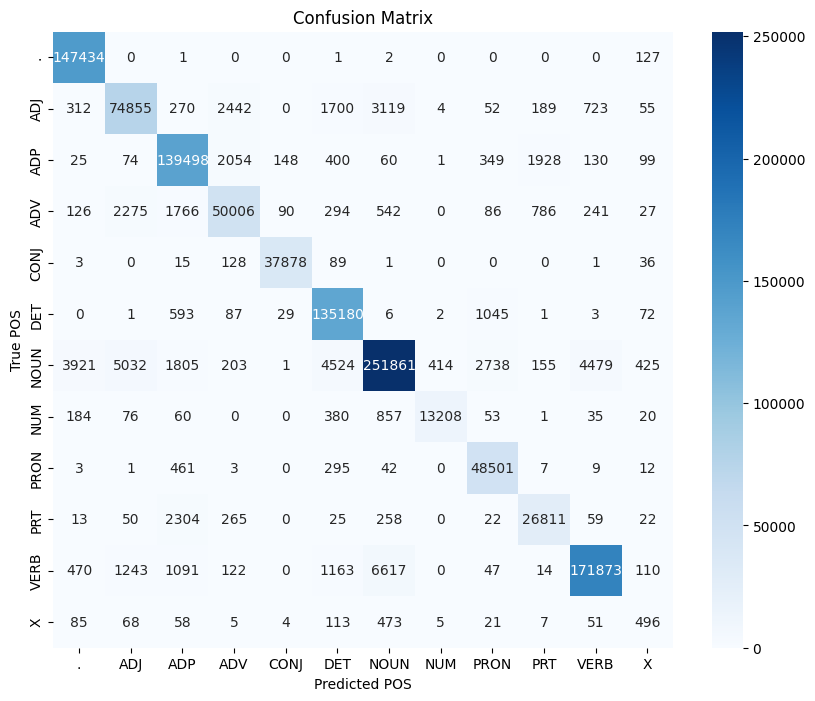


Overall Metrics:
Precision: 0.9455
Recall: 0.9452
F1-Score: 0.9451
F0.5-Score: 0.9453
F2-Score: 0.9451

Detailed POS Tagging Report (Precision, Recall, F1, F0.5, F2):
 Tag  Precision   Recall  F1-Score  F0.5-Score  F2-Score
   .   0.966299 0.999112  0.982432    0.972688  0.992372
 ADJ   0.894592 0.894101  0.894346    0.894494  0.894199
 ADP   0.943051 0.963610  0.953220    0.947092  0.959427
 ADV   0.904022 0.889169  0.896534    0.901012  0.892101
CONJ   0.992870 0.992844  0.992857    0.992865  0.992849
 DET   0.937682 0.986579  0.961509    0.947070  0.976395
NOUN   0.954605 0.914004  0.933863    0.946198  0.921845
 NUM   0.968755 0.887992  0.926617    0.951448  0.903049
PRON   0.916601 0.983115  0.948693    0.929174  0.969051
 PRT   0.896719 0.898823  0.897770    0.897139  0.898402
VERB   0.967732 0.940482  0.953912    0.962156  0.945808
   X   0.330446 0.357864  0.343609    0.335589  0.352023


In [6]:
def run_cross_validation(corpus, n_folds=5):
    all_tags = set()
    all_predictions = []
    all_true_labels = []

    for fold in range(n_folds):
        train_data, test_data = split_data(corpus, fold)

        # Train HMM on the training data
        hmm = HMM(train_data)

        for sentence in test_data:
            words = [word for word, tag in sentence]
            true_tags = [tag for word, tag in sentence]

            predicted_tags = hmm.viterbi(words)

            all_true_labels.extend(true_tags)
            all_predictions.extend(predicted_tags)
            all_tags.update(true_tags)

    return all_true_labels, all_predictions, sorted(list(all_tags))

# Run 5-fold cross-validation
true_labels, predicted_labels, tags = run_cross_validation(corpus)

# Overall Accuracy
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f'Overall Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=tags)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=tags, yticklabels=tags, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True POS')
plt.xlabel('Predicted POS')
plt.show()

# Compute per-tag precision, recall, f1-score, f0.5, and f2 scores
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=tags, average=None)
f05_score = precision_recall_fscore_support(true_labels, predicted_labels, labels=tags, average=None, beta=0.5)[2]
f2_score = precision_recall_fscore_support(true_labels, predicted_labels, labels=tags, average=None, beta=2)[2]

# Compute overall metrics (weighted average)
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
overall_f05_score = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', beta=0.5)[2]
overall_f2_score = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', beta=2)[2]

# Print overall metrics
print(f'\nOverall Metrics:')
print(f'Precision: {overall_precision:.4f}')
print(f'Recall: {overall_recall:.4f}')
print(f'F1-Score: {overall_f1_score:.4f}')
print(f'F0.5-Score: {overall_f05_score:.4f}')
print(f'F2-Score: {overall_f2_score:.4f}')

# Create a DataFrame to display per-tag metrics in a table format
metrics_df = pd.DataFrame({
    'Tag': tags,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'F0.5-Score': f05_score,
    'F2-Score': f2_score
})

# Display the table for per-tag metrics
print("\nDetailed POS Tagging Report (Precision, Recall, F1, F0.5, F2):")
print(metrics_df.to_string(index=False))


In [8]:
def tag_sentence(sentence, train_data):
    hmm = HMM(train_data)
    predicted_tags = hmm.viterbi(sentence.split())
    return list(zip(sentence.split(), predicted_tags))

# Gradio Interface Function
def pos_tagger(sentence):
    tagged_sentence = tag_sentence(sentence, corpus)
    # Formatting the output to make it more readable
    return "\n".join([f"{word}: {tag}" for word, tag in tagged_sentence])

# Create Gradio Interface
interface = gr.Interface(
    fn=pos_tagger,                # Function to be executed
    inputs="text",                # Input type is text
    outputs="text",               # Output type is text
    title="POS Tagger",           # Title of the application
    description="Enter a sentence to get POS tags",  # Description of the app
)

# Launch the Gradio interface
interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://4ae1b0453073b2c130.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [9]:
def tag_sentence(sentence, train_data):
    hmm = HMM(train_data)
    predicted_tags = hmm.viterbi(sentence.split())
    return list(zip(sentence.split(), predicted_tags))

def print_pos_tags(sentences):
    for sentence in sentences:
        tagged_sentence = tag_sentence(sentence, corpus)
        print("\n".join([f"{word}: {tag}" for word, tag in tagged_sentence]))
        print()

sentences = [
    # HMM is better
    "The cat sat.",
    "He runs every day.",
    "Birds fly south.",
    "They played soccer.",
    "Dogs bark at night.",
    "She sings beautifully.",
    "The sun shines bright.",
    "It is raining.",
    "The car is red.",
    "He ate lunch.",
    
    # CRF is better
    "The bank can refuse to lend.",
    "I watched her lead the team.",
    "He saw her duck.",
    "The old man the boat.",
    "She likes to cook.",
    "The novel is a great read.",
    "He left the room quietly.",
    "The chicken is on the table.",
    "The committee made a decision.",
    "She gave her friend a gift.",
    
    # Both are equal
    "They are going to the park.",
    "I love playing the guitar.",
    "She is reading a book.",
    "We enjoy hiking during the summer.",
    "He writes stories.",
    "The flowers bloom in spring.",
    "Cats and dogs are popular pets.",
    "The teacher explained the lesson.",
    "They danced all night.",
    "I finished my homework."
]
print_pos_tags(sentences)

The: DET
cat: NOUN
sat.: .

He: PRON
runs: VERB
every: DET
day.: NOUN

Birds: NOUN
fly: VERB
south.: VERB

They: PRON
played: VERB
soccer.: VERB

Dogs: NOUN
bark: NOUN
at: ADP
night.: DET

She: PRON
sings: VERB
beautifully.: VERB

The: DET
sun: NOUN
shines: VERB
bright.: VERB

It: PRON
is: VERB
raining.: VERB

The: DET
car: NOUN
is: VERB
red.: VERB

He: PRON
ate: VERB
lunch.: VERB

The: DET
bank: NOUN
can: VERB
refuse: VERB
to: PRT
lend.: VERB

I: PRON
watched: VERB
her: PRON
lead: VERB
the: DET
team.: NOUN

He: PRON
saw: VERB
her: DET
duck.: NOUN

The: DET
old: ADJ
man: NOUN
the: DET
boat.: NOUN

She: PRON
likes: VERB
to: PRT
cook.: VERB

The: DET
novel: NOUN
is: VERB
a: DET
great: ADJ
read.: NOUN

He: PRON
left: VERB
the: DET
room: NOUN
quietly.: .

The: DET
chicken: NOUN
is: VERB
on: ADP
the: DET
table.: NOUN

The: DET
committee: NOUN
made: VERB
a: DET
decision.: NOUN

She: PRON
gave: VERB
her: DET
friend: NOUN
a: DET
gift.: NOUN

They: PRON
are: VERB
going: VERB
to: ADP
the: DET
pa

In [62]:
# Benchmarking against ChatGPT
"""
Sentence 1:

	•	Sentence: “The quick brown fox jumps over the lazy dog.”
	•	True Labels:
	•	[‘DET’, ‘ADJ’, ‘ADJ’, ‘NOUN’, ‘VERB’, ‘ADP’, ‘DET’, ‘ADJ’, ‘NOUN’]
	•	ChatGPT Predictions:
	•	[‘DET’, ‘ADJ’, ‘ADJ’, ‘NOUN’, ‘VERB’, ‘ADP’, ‘DET’, ‘ADJ’, ‘NOUN’]

Sentence 2:

	•	Sentence: “He will run fast.”
	•	True Labels:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘ADV’]
	•	ChatGPT Predictions:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘ADJ’]  # Incorrect: ‘ADV’ predicted as ‘ADJ’

Sentence 3:

	•	Sentence: “Cats are wonderful pets.”
	•	True Labels:
	•	[‘NOUN’, ‘AUX’, ‘ADJ’, ‘NOUN’]
	•	ChatGPT Predictions:
	•	[‘NOUN’, ‘AUX’, ‘ADJ’, ‘NOUN’]

Sentence 4:

	•	Sentence: “They are playing soccer.”
	•	True Labels:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘NOUN’]
	•	ChatGPT Predictions:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘NOUN’]

Sentence 5:

	•	Sentence: “The movie was fantastic.”
	•	True Labels:
	•	[‘DET’, ‘NOUN’, ‘AUX’, ‘ADJ’]
	•	ChatGPT Predictions:
	•	[‘DET’, ‘NOUN’, ‘AUX’, ‘ADJ’]

Sentence 6:

	•	Sentence: “She sings beautifully.”
	•	True Labels:
	•	[‘PRON’, ‘VERB’, ‘ADV’]
	•	ChatGPT Predictions:
	•	[‘PRON’, ‘VERB’, ‘ADV’]

Sentence 7:

	•	Sentence: “It rained heavily last night.”
	•	True Labels:
	•	[‘PRON’, ‘VERB’, ‘ADV’, ‘ADJ’, ‘NOUN’]
	•	ChatGPT Predictions:
	•	[‘PRON’, ‘VERB’, ‘ADV’, ‘ADJ’, ‘NOUN’]

Sentence 8:

	•	Sentence: “Where did you go?”
	•	True Labels:
	•	[‘ADV’, ‘AUX’, ‘PRON’, ‘VERB’]
	•	ChatGPT Predictions:
	•	[‘ADV’, ‘AUX’, ‘PRON’, ‘VERB’]

Sentence 9:

	•	Sentence: “This is a beautiful painting.”
	•	True Labels:
	•	[‘DET’, ‘AUX’, ‘DET’, ‘ADJ’, ‘NOUN’]
	•	ChatGPT Predictions:
	•	[‘DET’, ‘AUX’, ‘DET’, ‘ADJ’, ‘NOUN’]

Sentence 10:

	•	Sentence: “I have eaten lunch already.”
	•	True Labels:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘NOUN’, ‘ADV’]
	•	ChatGPT Predictions:
	•	[‘PRON’, ‘AUX’, ‘VERB’, ‘NOUN’, ‘ADV’]

"""
# from the above sentences:

# Ground truth POS tags
true_labels = [
    'DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN',  # Sentence 1
    'PRON', 'AUX', 'VERB', 'ADV',                                      # Sentence 2
    'NOUN', 'AUX', 'ADJ', 'NOUN',                                      # Sentence 3
    'PRON', 'AUX', 'VERB', 'NOUN',                                     # Sentence 4
    'DET', 'NOUN', 'AUX', 'ADJ',                                       # Sentence 5
    'PRON', 'VERB', 'ADV',                                             # Sentence 6
    'PRON', 'VERB', 'ADV', 'ADJ', 'NOUN',                              # Sentence 7
    'ADV', 'AUX', 'PRON', 'VERB',                                      # Sentence 8
    'DET', 'AUX', 'DET', 'ADJ', 'NOUN',                                # Sentence 9
    'PRON', 'AUX', 'VERB', 'NOUN', 'ADV'                               # Sentence 10
]

# ChatGPT POS tags predictions
chatgpt_preds = [
    'DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN',  # Sentence 1
    'PRON', 'AUX', 'VERB', 'ADJ',                                      # Sentence 2
    'NOUN', 'AUX', 'ADJ', 'NOUN',                                      # Sentence 3
    'PRON', 'AUX', 'VERB', 'NOUN',                                     # Sentence 4
    'DET', 'NOUN', 'AUX', 'ADJ',                                       # Sentence 5
    'PRON', 'VERB', 'ADV',                                             # Sentence 6
    'PRON', 'VERB', 'ADV', 'ADJ', 'NOUN',                              # Sentence 7
    'ADV', 'AUX', 'PRON', 'VERB',                                      # Sentence 8
    'DET', 'AUX', 'DET', 'ADJ', 'NOUN',                                # Sentence 9
    'PRON', 'AUX', 'VERB', 'NOUN', 'ADV'                               # Sentence 10
]

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, chatgpt_preds, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.9813829787234043
Recall: 0.9787234042553191
F1-Score: 0.9782505910165484


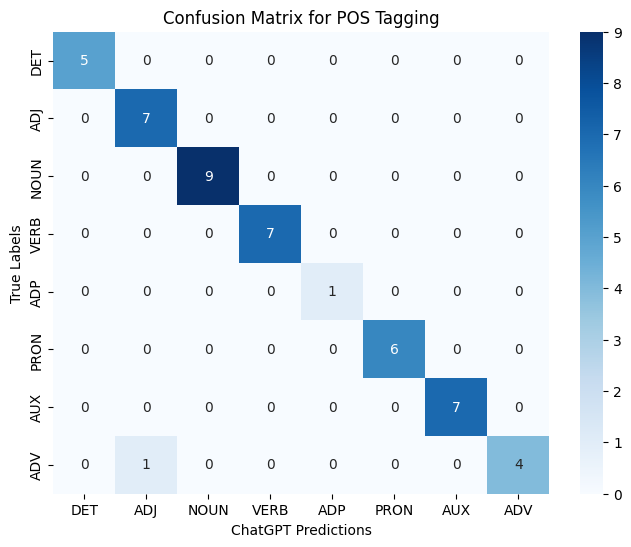

In [63]:
# confusion Matrix
# List of unique POS tags in the dataset
pos_labels = ['DET', 'ADJ', 'NOUN', 'VERB', 'ADP', 'PRON', 'AUX', 'ADV']

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, chatgpt_preds, labels=pos_labels)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pos_labels, yticklabels=pos_labels)
plt.xlabel('ChatGPT Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for POS Tagging')
plt.show()